In [1]:
import os
import sys
# sys.path.append('/home/evanlee/PBMC_Hao')
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_lossdiff as ad

import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy
import json
import time

In [2]:
### B cells
celltype = 'B'

# Read adata (Use full dataset or only representative cells)
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
adata = sc.read_h5ad('/home/jovyan/work/Research_datasets/GSE164378/Hao_PBMC_GSE_level1_rep_cells_onlyLog1p.h5ad')
print('Original adata:', adata.shape)  # (32349, 20568)

### Remove the genes whose expression is zero in all cells of this celltype
adata_celltype = adata[adata.obs['celltype.l1'] == celltype]
print('adata celltype shape:', adata_celltype.shape)

# Remove explicit zeros from the sparse matrix
adata_celltype.X.eliminate_zeros()

# Find the columns that are all zeros
all_zeros = np.where(adata_celltype.X.getnnz(axis=0) == 0)[0]

# Remove the columns that are all zeros from the anndata object
adata = adata[:, ~adata_celltype.var_names.isin(adata_celltype.var_names[all_zeros])]
print('adata shape after removing all zero columns for celltype cells:', adata.shape)
del adata_celltype, all_zeros

# L1 celltype as labels
label = adata.obs['celltype.l1'].tolist()

### Read optimal lambda dictionary from json
path_opt_lambda = '/home/jovyan/work/GitHub/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/GSE_L1_loss_diff_opt_lmbd.json'
with open(path_opt_lambda, 'r') as f:
    opt_lambda_dict = json.load(f)
opt_lmbd = opt_lambda_dict[celltype]
print('optimal lambda:', opt_lmbd)  # optimal lambda for B cells is 0.01


Original adata: (32349, 33538)
adata celltype shape: (2760, 33538)
adata shape after removing all zero columns for celltype cells: (32349, 20086)
optimal lambda: 0.010000000000000004


In [3]:
# Build ADlasso model
# Binary classification of a celltype
celltype_label = [1 if x == celltype else 0 for x in label]
# create index for a celltype
celltype_indices = [idx for idx, label in enumerate(celltype_label) if label == 1]

# Find marker genes with optimal lambda
pvl = ad.get_prevalence(adata.X, celltype_indices)
print('Fitting with optimal lambda:', opt_lmbd)

opt_res = ad.ADlasso2(lmbd=opt_lmbd, loss_tol=1e-6, echo=True, device='cuda')  # cuda
opt_res.fit(adata.X, celltype_label, pvl)

Fitting with optimal lambda: 0.010000000000000004
At iteration 513, Convergence with loss difference
Convergence with loss difference
minimum epoch =  514 ; minimum lost =  0.07772774249315262 ; diff weight =  9.298486838815734e-05


In [7]:
# B cell selected 12 features
sum(opt_res.feature_set == 1)

12

In [14]:
prop = ad.featureProperty(adata.X, celltype_label, opt_res)
prop['featureID'] = adata.var_names

In [15]:
prop
# prevalence: get_prevalence(X_, np.arange(X_.shape[0]))
# prevalence_0: get_prevalence(X_, class0Idx)
# prevalence_1: get_prevalence(X_, class1Idx)

meanAbundance  Variance       select  prevalence  prevalence_0  \
0           0.002005  0.001400  No selected    0.002875      0.002906   
1           0.000107  0.000074  No selected    0.000155      0.000135   
2           0.041373  0.028949  No selected    0.057189      0.053026   
3           0.000557  0.000386  No selected    0.000804      0.000811   
4           0.018997  0.013415  No selected    0.026616      0.026192   
...              ...       ...          ...         ...           ...   
20081       0.006330  0.004499  No selected    0.008934      0.007908   
20082       0.016185  0.012152  No selected    0.021886      0.022677   
20083       0.000337  0.000451  No selected    0.000340      0.000034   
20084       0.001536  0.002437  No selected    0.001329      0.000034   
20085       0.028068  0.020639  No selected    0.038023      0.037379   

       prevalence_1   featureID  
0          0.002536  AL627309.1  
1          0.000362  AL669831.2  
2          0.101812  AL669831.5  
3          0.000725      FAM87B  
4          0.031159   LINC00115  
...             ...         ...  
20081      0.019928  AL354822.1  
20082      0.013406  AC004556.1  
20083      0.003623  AC233755.2  
20084      0.015217  AC233755.1  
20085      0.044928  AC240274.1  

[20086 rows x 7 columns]

[None]

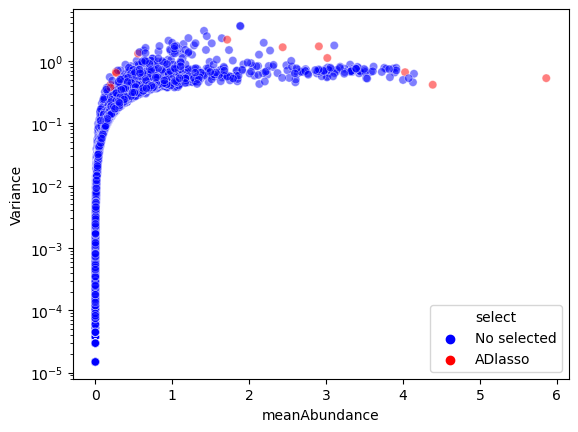

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
g =sns.scatterplot(x="meanAbundance", y="Variance", hue="select",palette=['b', 'r'], alpha = 0.5, data=prop)
g.set(yscale="log")

[None]

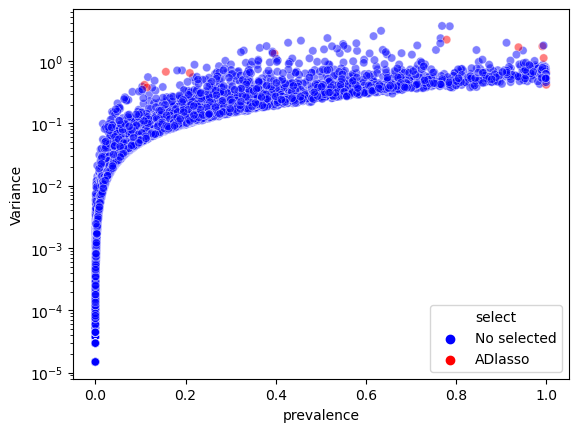

In [20]:
g =sns.scatterplot(x="prevalence", y="Variance", hue="select",palette=['b', 'r'], alpha = 0.5, data=prop)
g.set(yscale="log")

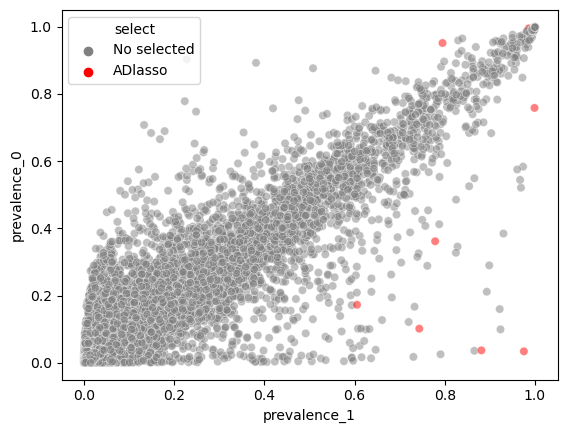

In [24]:
g =sns.scatterplot(x="prevalence_1", y="prevalence_0", hue="select",palette=['grey', 'r'], alpha = 0.5, data=prop)

In [32]:
len(opt_res.w)

20086

In [26]:
opt_res.w[opt_res.w != 0]

array([-0.16422378,  0.39107278,  0.36212027, -0.07926341, -0.43459678,
        0.81233853, -0.11053321, -0.31372616,  0.05357509, -0.19905192,
        1.7377862 ,  0.20239902], dtype=float32)

In [27]:
opt_res.w[opt_res.w > 0]

array([0.39107278, 0.36212027, 0.81233853, 0.05357509, 1.7377862 ,
       0.20239902], dtype=float32)

In [31]:
opt_res.writeList(outpath='./B_features.txt', featureNameList=adata.var_names)

In [36]:
np.unique(opt_res.feature_set)

array([0, 1])

In [37]:
opt_res.classes_

{0: 0, 1: 1}

In [33]:
# DIY: feature property dataframe
def feature_property(

In [46]:
import importlib
import ADlasso2.AD2_w_utils_lossdiff as ad

# Reload the module
importlib.reload(ad)

<module 'ADlasso2.AD2_w_utils_lossdiff' from '/home/jovyan/work/GitHub/EvanPys/Progress/ADlasso2/AD2_w_utils_lossdiff.py'>

In [47]:
prop = ad.featureProperty(adata.X, celltype_label, opt_res)
prop['featureID'] = adata.var_names

In [48]:
prop

meanAbundance  Variance       select  prevalence  prevalence_0  \
0           0.002005  0.001400  No selected    0.002875      0.002906   
1           0.000107  0.000074  No selected    0.000155      0.000135   
2           0.041373  0.028949  No selected    0.057189      0.053026   
3           0.000557  0.000386  No selected    0.000804      0.000811   
4           0.018997  0.013415  No selected    0.026616      0.026192   
...              ...       ...          ...         ...           ...   
20081       0.006330  0.004499  No selected    0.008934      0.007908   
20082       0.016185  0.012152  No selected    0.021886      0.022677   
20083       0.000337  0.000451  No selected    0.000340      0.000034   
20084       0.001536  0.002437  No selected    0.001329      0.000034   
20085       0.028068  0.020639  No selected    0.038023      0.037379   

       prevalence_1   featureID  
0          0.002536  AL627309.1  
1          0.000362  AL669831.2  
2          0.101812  AL669831.5  
3          0.000725      FAM87B  
4          0.031159   LINC00115  
...             ...         ...  
20081      0.019928  AL354822.1  
20082      0.013406  AC004556.1  
20083      0.003623  AC233755.2  
20084      0.015217  AC233755.1  
20085      0.044928  AC240274.1  

[20086 rows x 7 columns]

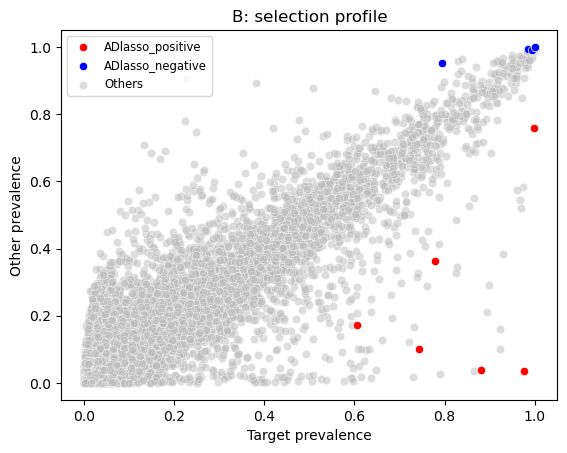

In [77]:
# Filter the data
positive_data = prop[prop['select'] == 'ADlasso_positive']
negative_data = prop[prop['select'] == 'ADlasso_negative']
other_data = prop[prop['select'] == 'No selected']

# Plot the other dots with grey color and alpha=0.5
sns.scatterplot(x="prevalence_1", y="prevalence_0", color='#BCBCBC', alpha=0.5, data=other_data, label='Others')
# Plot the positive dots with red color and alpha=1
sns.scatterplot(x="prevalence_1", y="prevalence_0", color='r', alpha=1, data=positive_data, label='ADlasso_positive')
# Plot the negative dots with blue color and alpha=1
sns.scatterplot(x="prevalence_1", y="prevalence_0", color='b', alpha=1, data=negative_data, label='ADlasso_negative')

# Get the current axes
ax = plt.gca()

# Get the handles and labels from the scatterplot
handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 0]
# Set the legend
plt.legend(handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order], loc='upper left', fontsize='small')
plt.xlabel('Target prevalence')
plt.ylabel('Other prevalence')
plt.title('B: selection profile')
plt.show()